# このNotebookについて

このNotebookでは複数の画像と車両情報の特徴量を使ったモデルのベースラインを紹介します！

このベースラインではシンプルに3つのタイムポイントの画像をチャンネル方向に結合して画像エンコーダモデル（ここではresnet18）に入力しています。これはTuringのしおさんという方がTech blogで公開してくれているモデルを参考にして作成しています。

- ブログ: [【TURING】End-to-Endで限定コースをぐるぐる走る機械学習モデルを作って実際に車を動かした話【自動運転】](https://zenn.dev/turing_motors/articles/budapest_tech_blog)

さらに、4年前にKaggleで開催された「[Lyft Motion Prediction for Autonomous Vehicles](https://www.kaggle.com/competitions/lyft-motion-prediction-autonomous-vehicles)」というコンペでも同様に入力画像をチャンネル方向に結合したモデルが使用されていました。Lyftのコンペティションは入力画像がラスタライズされた鳥観図ではありますが、十分なデータがあればDeep learning modelがそのあたりはよしなに学習してくれると思います。

画像に加えて車両の状態に関するデータの特徴量も与えられており、この情報もかなり有力な情報なのは間違いないです。実際にnasukaさんの[[LB: 0.2766] Hyper Simple Baseline](https://www.guruguru.science/competitions/25/discussions/624532d4-e0c4-47db-b034-f0b12713b10d/)でも、画像情報なしでかなり予測できていることがわかります。このベースラインでは、車両の状態に関するデータは単純にそのままMLPにかけて、画像エンコーダから抽出した特徴ベクトルと結合し、最終的なターゲット予測を行うようなLayerを最後に入れています。このあたりの設計は、このベースラインではかなりシンプルに行っているので、ここを工夫するだけでも簡単にスコアが上がると思います。

こちらのベースラインコードは使いまわしている部分も多く、全体的に長くて雑多なのでわかりにくいところもあるかと思います。コードに関することやアイディアに関すること、何かあればぜひ気軽にDiscussionにコメントください！1週間頑張っていきましょう！！！

### Version 1
- ValidationのMAEが`0.2487`、Public LBは`0.2641`でした。

### Version 2
- 5 Foldで学習・推論できるようにしました。
- 恣意的な値でですが車両の状態データを0付近になるようにスケーリングしました。
- `gearShifter`も特徴量に加えました。
- 画像サイズを大きくしました (GPUの使用率は8GBちょいです)
- この設定で、ValidationのMAEが`0.2394`、Public LBは`0.2448`でした。

### Version 3
- Claudeを用いて車両情報の特徴量の前処理をさせる関数を生成しました。
- 信号機をラベルごとに1チャンネル割り当てた画像のようなデータにして、入力画像にConcatしました。
- 画像の正規化が少し間違っていたので修正しました。
- この設定で、ValidationのMAEが`0.2353`、Public LBは`0.2387`でした。

### Version 4
- [Depth Anything v2](https://github.com/DepthAnything/Depth-Anything-V2)で作成した深度情報を入力に加えました。
- この設定で、ValidationのMAEが`0.2329`、Public LBは`0.2350`でした。


**このNotebookをもとにいろいろ調整していったもので、ValidationのMAEが`0.2119`、Public LBは`0.2073`です。**

# 前処理に使うライブラリ

In [1]:
import os
import sys
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_columns", 100)

# 可視化に使う関数

In [2]:
# Special Thanks to Arai-san
# see: https://www.guruguru.science/competitions/25/discussions/b75b30bb-abcd-482d-b43a-fa325748e48d/

"""
文字数の都合でコードを配置できなかったので、一番最後の「結果が妥当かどうかを確認する」を実行する場合は、あらいさんのDiscussionから関数をコピーしてきてください。

def camera_to_image():
    ...

# 変更しないでください
intrinsic_matrix = ...

def project_trajectory_to_image_coordinate_system():
    ...

def overlay_trajectory():
    ...
"""

In [3]:
def convert_target_to_visible_trajectory(label: pd.Series) -> np.array:
    pivot_df = label.to_frame().reset_index()
    pivot_df.columns = ['coordinate', 'value']  # カラム名を設定
    
    # coordinate列から座標軸(x,y,z)と番号を分割
    pivot_df[['axis', 'number']] = pivot_df['coordinate'].str.extract(r'([xyz])_(\d+)')
    
    # pivotを実行
    trajectory = pivot_df.pivot(index='number', columns='axis', values='value')
    
    # インデックスを数値型に変換して整理
    trajectory.index = trajectory.index.astype(int)
    trajectory = trajectory.sort_index().values
    return trajectory

# Dataの前処理に関するConfig

In [4]:
PATH_TO_DATASET = "../data"
def get_relative_path(path):
    return os.path.join(PATH_TO_DATASET, path)

# 画像へのパス
image_path_root_list = [
    get_relative_path("atmaCup18_dataset/images/{ID}/image_t.png"),
    get_relative_path("atmaCup18_dataset/images/{ID}/image_t-0.5.png"),
    get_relative_path("atmaCup18_dataset/images/{ID}/image_t-1.0.png")
]

# Depthへのパス
depth_path_root_list = [
    get_relative_path("atmaCup18_dataset/depth/{ID}/image_t.png"),
    get_relative_path("atmaCup18_dataset/depth/{ID}/image_t-0.5.png"),
    get_relative_path("atmaCup18_dataset/depth/{ID}/image_t-1.0.png")
]

# 特徴量のパス
train_feature_path = get_relative_path("atmaCup18_dataset/train_features.csv")
traffic_light_path = get_relative_path("atmaCup18_dataset/traffic_lights/{ID}.json")

# 信号機の情報へのパス
test_feature_path = get_relative_path("atmaCup18_dataset/test_features.csv")

# サンプルサブミッション
sample_submission_path = get_relative_path("atmaCup18__sample_submit.csv")

# ========================================
# DataFrameの読み込み
# ========================================
df_feature_train = pd.read_csv(train_feature_path)
df_feature_test = pd.read_csv(test_feature_path)
df_sample_submission = pd.read_csv(sample_submission_path)

# Config
TARGET_COLUMNS = df_sample_submission.columns
N_FOLD = 5

# 車両状態のデータの簡単な正規化とClaudeが教えてくれた特徴量生成

In [ ]:
# claudeにいい感じで特徴量作ってとお願いしたらこれが出てきました
def create_features(df):
    features = df.copy()
    original_cols = df.columns

    # Scene IDを抽出
    features['scene_id'] = features['ID'].apply(lambda x: x.split('_')[0])

    # 1. 基本的な統計量の計算（各シーンごと）
    scene_stats = features.groupby('scene_id').agg({
        'vEgo': ['mean', 'std', 'min', 'max', 'median'],
        'aEgo': ['mean', 'std', 'min', 'max', 'median'],
        'steeringAngleDeg': ['mean', 'std', 'min', 'max', 'median'],
        'steeringTorque': ['mean', 'std', 'min', 'max', 'median'],
        'brake': ['mean', 'max', 'sum'],
        'gas': ['mean', 'max', 'sum']
    })

    # 2. 運転スタイルに関する特徴量
    features['harsh_acceleration'] = (features['aEgo'] > 2.0).astype(int)
    features['harsh_braking'] = (features['aEgo'] < -2.0).astype(int)

    # 急ハンドルの回数
    features['sharp_steering'] = (abs(features['steeringAngleDeg']) > 45).astype(int)

    # シーンごとの集計
    driving_style = features.groupby('scene_id').agg({
        'harsh_acceleration': 'sum',
        'harsh_braking': 'sum',
        'sharp_steering': 'sum'
    })

    # 3. 運転の滑らかさに関する特徴量
    features['speed_change_rate'] = features.groupby('scene_id')['vEgo'].diff()

    # ステアリングの変化率
    features['steering_change_rate'] = features.groupby('scene_id')['steeringAngleDeg'].diff()

    # 変化率の統計量
    smoothness_stats = features.groupby('scene_id').agg({
        'speed_change_rate': ['std', 'max', 'min'],
        'steering_change_rate': ['std', 'max', 'min']
    })

    # 4. ペダル操作に関する特徴量
    pedal_features = features.groupby('scene_id').agg({
        'brakePressed': 'sum',  # ブレーキを踏んでいる時間
        'gasPressed': 'sum',    # アクセルを踏んでいる時間
        'brake': 'mean',        # 平均ブレーキ圧
        'gas': 'mean'          # 平均アクセル開度
    })

    # 5. ウィンカー使用に関する特徴量
    blinker_features = features.groupby('scene_id').agg({
        'leftBlinker': 'sum',   # 左ウィンカーの使用時間
        'rightBlinker': 'sum'   # 右ウィンカーの使用時間
    })

    # 6. 高度な特徴量
    features['speed_zone'] = pd.qcut(features['vEgo'], q=5, labels=['very_slow', 'slow', 'medium', 'fast', 'very_fast'])
    speed_profile = pd.crosstab(features['scene_id'], features['speed_zone'], normalize='index')

    # 加速度プロファイルの特徴
    features['acc_zone'] = pd.qcut(features['aEgo'], q=5, labels=['hard_brake', 'mild_brake', 'neutral', 'mild_acc', 'hard_acc'])
    acc_profile = pd.crosstab(features['scene_id'], features['acc_zone'], normalize='index')

    # 7. 時系列特徴量
    def lag_features(group):
        return pd.Series({
            'speed_autocorr': group['vEgo'].autocorr(),
            'steering_autocorr': group['steeringAngleDeg'].autocorr()
        })

    time_features = features.groupby('scene_id').apply(lag_features)

    # 8. 運転の一貫性に関する特徴量
    def consistency_features(group):
        return pd.Series({
            'speed_consistency': 1 - (group['vEgo'].std() / (group['vEgo'].mean() + 1e-6)),
            'steering_consistency': 1 - (group['steeringAngleDeg'].std() / (abs(group['steeringAngleDeg']).mean() + 1e-6))
        })

    consistency = features.groupby('scene_id').apply(consistency_features)

    # 全ての特徴量を結合
    all_features = pd.concat([
        scene_stats,
        driving_style,
        smoothness_stats,
        pedal_features,
        blinker_features,
        speed_profile,
        acc_profile,
        time_features,
        consistency
    ], axis=1)

    # カラム名を平坦化
    all_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in all_features.columns]
    drop_cols = set(original_cols) & set(all_features.columns)

    return all_features.drop(drop_cols, axis=1)

In [6]:
# Sceneの名前を抜き出してDataFrameに加える
df_feature_train["scene"] = [i.split("_")[0] for i in df_feature_train.ID]
df_feature_test["scene"] = [i.split("_")[0] for i in df_feature_test.ID]


df_feature_train["is_train"] = True
df_feature_test["is_train"] = False

df_feature = pd.concat([
    df_feature_train,
    df_feature_test
], axis=0, ignore_index=True)

# feature engineering
df_feature.vEgo = df_feature.vEgo / 30
df_feature.aEgo = df_feature.aEgo
df_feature.steeringAngleDeg = df_feature.steeringAngleDeg / 400
df_feature.steeringTorque = df_feature.steeringTorque / 600

gear_cols = []
for gear_shift in df_feature.gearShifter.value_counts().index:
    col_name = f"label_{gear_shift}"
    gear_cols.append(col_name)
    df_feature[col_name] = 0
    df_feature.loc[df_feature.gearShifter == gear_shift, col_name] = 1

all_features = create_features(df_feature)
df_feature = df_feature.merge(all_features.fillna(0), left_on="scene", right_index=True)

df_feature_train = df_feature[df_feature.is_train == True].reset_index(drop=True)
df_feature_test = df_feature[df_feature.is_train == False].drop(TARGET_COLUMNS, axis=1).reset_index(drop=True)

FEATIRE_COLMUNS = ['vEgo', 'aEgo', 'steeringAngleDeg', 'steeringTorque', 'brake', 'brakePressed', 'gas', 'gasPressed', 'leftBlinker', 'rightBlinker'] + gear_cols + list(all_features.columns)

/home/yuichi/workspace/kaggle/atmacup_18/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/yuichi/workspace/kaggle/atmacup_18/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/yuichi/workspace/kaggle/atmacup_18/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/yuichi/workspace/kaggle/atmacup_18/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yuichi/workspace/kaggle/atmacup_18/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2856

# 学習のための前処理

In [7]:
# =======================================
# 5 Foldの作成
# =======================================

# train/val split
# SceneでFoldを分ける
scene_list = df_feature_train.scene.unique()
fold_map = {}

for i, scene in enumerate(scene_list):
    fold_map[scene] = i % N_FOLD

df_feature_train["fold"] = df_feature_train.scene.map(fold_map)

# =======================================
# 画像のパスの追加
# =======================================
df_feature_train["img_path_t_00"] = [image_path_root_list[0].format(ID=ID) for ID in df_feature_train.ID]
df_feature_train["img_path_t_05"] = [image_path_root_list[1].format(ID=ID) for ID in df_feature_train.ID]
df_feature_train["img_path_t_10"] = [image_path_root_list[2].format(ID=ID) for ID in df_feature_train.ID]

df_feature_test["img_path_t_00"] = [image_path_root_list[0].format(ID=ID) for ID in df_feature_test.ID]
df_feature_test["img_path_t_05"] = [image_path_root_list[1].format(ID=ID) for ID in df_feature_test.ID]
df_feature_test["img_path_t_10"] = [image_path_root_list[2].format(ID=ID) for ID in df_feature_test.ID]

# =======================================
# Depthのパスの追加
# =======================================
df_feature_train["depth_path_t_00"] = [depth_path_root_list[0].format(ID=ID) for ID in df_feature_train.ID]
df_feature_train["depth_path_t_05"] = [depth_path_root_list[1].format(ID=ID) for ID in df_feature_train.ID]
df_feature_train["depth_path_t_10"] = [depth_path_root_list[2].format(ID=ID) for ID in df_feature_train.ID]

df_feature_test["depth_path_t_00"] = [depth_path_root_list[0].format(ID=ID) for ID in df_feature_test.ID]
df_feature_test["depth_path_t_05"] = [depth_path_root_list[1].format(ID=ID) for ID in df_feature_test.ID]
df_feature_test["depth_path_t_10"] = [depth_path_root_list[2].format(ID=ID) for ID in df_feature_test.ID]

# ベースラインモデルの作成

In [11]:
import json
import logging
import random
import time
import warnings

import albumentations as A
import timm
import torch
import torch.nn.functional as F
import wandb
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from albumentations.pytorch import ToTensorV2
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

# 学習関連に使うUtil関数

In [12]:
LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

def setup_logger(out_file=None, stderr=True, stderr_level=logging.INFO, file_level=logging.DEBUG):
    LOGGER.handlers = []
    LOGGER.setLevel(min(stderr_level, file_level))

    if stderr:
        handler = logging.StreamHandler(sys.stderr)
        handler.setFormatter(FORMATTER)
        handler.setLevel(stderr_level)
        LOGGER.addHandler(handler)

    if out_file is not None:
        handler = logging.FileHandler(out_file)
        handler.setFormatter(FORMATTER)
        handler.setLevel(file_level)
        LOGGER.addHandler(handler)

    LOGGER.info("logger set up")
    return LOGGER

def seed_torch(seed=516):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def mae(gt: np.array, pred: np.array) -> float:
    abs_diff = np.abs(gt - pred)
    mae = np.mean(abs_diff.reshape(-1, ))
    return mae.astype(float)

# 信号機の画像化

In [ ]:
class TrafficLightMaskGenerator:
    def __init__(self, image_size: list[int, int] | int | None = None):
        self.original_size = (128, 64)  # (width, height)

        if image_size == None:
            self.image_size = self.original_size
        elif isinstance(image_size, list):
            self.image_size = (image_size[1], image_size[0])  # (width, height)
        elif isinstance(image_size, int):
            self.image_size = (image_size, image_size)

        self.scale_x = self.image_size[0] / self.original_size[0]
        self.scale_y = self.image_size[1] / self.original_size[1]

        self.traffic_light_classes = [
            'green', 'yellow', 'red', 'straight',
            'left', 'right', 'empty', 'other'
        ]
        self.class_to_index = {
            cls: idx for idx, cls in enumerate(self.traffic_light_classes)
        }

    def scale_bbox(self, bbox):
        x1, y1, x2, y2 = bbox
        scaled_bbox = [
            x1 * self.scale_x,  # x1
            y1 * self.scale_y,  # y1
            x2 * self.scale_x,  # x2
            y2 * self.scale_y   # y2
        ]
        return scaled_bbox

    def generate_masks(self, traffic_lights_json):
        if isinstance(traffic_lights_json, str):
            with open(traffic_lights_json, "r") as f:
                traffic_lights = json.load(f)
        else:
            traffic_lights = traffic_lights_json

        # クラス数分のチャンネルを持つ空の配列を作成
        masks = np.zeros((self.image_size[1], self.image_size[0], 
                         len(self.traffic_light_classes)), dtype=np.float32)

        # 各信号機に対してマスクを生成
        for light in traffic_lights:
            class_idx = self.class_to_index[light['class']]
            scaled_bbox = self.scale_bbox(light['bbox'])

            x1, y1, x2, y2 = map(self._convert_coordinate, scaled_bbox)

            x1 = max(0, min(x1, self.image_size[0]-1))
            x2 = max(0, min(x2, self.image_size[0]-1))
            y1 = max(0, min(y1, self.image_size[1]-1))
            y2 = max(0, min(y2, self.image_size[1]-1))

            masks[y1:y2+1, x1:x2+1, class_idx] = 1.0

        return masks

    def _convert_coordinate(self, coord):
        return int(round(coord))

# Pytorch Datasetの定義

In [14]:
class CustomDataset(Dataset):
    feature_columns = FEATIRE_COLMUNS
    
    def __init__(self,
                 df,
                 transform=None,
                 mode="train",
                 target_columns=None,
                 traffic_light_gen=None,
                 is_depth=False,
                 ):
        self.df = df
        self.transform = transform

        self.mode = mode
        self.target_columns = target_columns
        self.traffic_light_gen = traffic_light_gen
        self.is_depth = is_depth

    def __len__(self):
        return self.df.shape[0]

    def extract_features(self, row: pd.Series) -> np.array:
        # ここで正規化や追加で特徴エンジニアリングを行う
        features = row[self.feature_columns].values * 1
        return features.astype(float)

    def __getitem__(self, index):
        ret = {}

        # 訓練・推論に必要な情報を取得する
        row = self.df.iloc[index]

        # =====================================
        # 画像情報の取得
        # =====================================
        # 画像をチャンネル方向に結合する
        images = [
            np.array(Image.open(row.img_path_t_00)),
            np.array(Image.open(row.img_path_t_05)),
            np.array(Image.open(row.img_path_t_10)),
        ]
        
        images = np.concatenate(images, axis=2)

        if self.transform is not None:
            aug = self.transform(image=images)                
            images = aug['image'].astype(np.float32).transpose(2, 0, 1) / 255
        else:
            images = images.transpose(2, 0, 1)

        # 信号機のラベルごとに1チャンネル割り当てて、画像にConcatする
        if self.traffic_light_gen is not None:
            traffic_image = self.traffic_light_gen.generate_masks(traffic_light_path.format(ID=row.ID))
            traffic_image = traffic_image.astype(np.float32).transpose(2, 0, 1)
            images = np.concatenate([images, traffic_image], axis=0)

        # Depth情報の追加
        if self.is_depth == True:
            _, image_height, image_width = images.shape
            depth_maps = [
                np.array(Image.open(row.depth_path_t_00).resize((image_width, image_height), Image.BILINEAR)),
                np.array(Image.open(row.depth_path_t_05).resize((image_width, image_height), Image.BILINEAR)),
                np.array(Image.open(row.depth_path_t_10).resize((image_width, image_height), Image.BILINEAR)),
            ]
            depth_maps = np.stack(depth_maps, axis=0) / 255
            images = np.concatenate([images, depth_maps], axis=0)
        
        ret["image"] = torch.tensor(images, dtype=torch.float)

        # =====================================
        # Table特徴量の取得
        # =====================================
        features = self.extract_features(row)
        ret["features"] = torch.tensor(features, dtype=torch.float)

        # =====================================
        # Targetの取得
        # =====================================
        if self.mode != "test":
            assert self.target_columns is not None, "target_columnsが設定されていません。"
            target = row[self.target_columns].values.astype(np.float16)
            ret["target"] = torch.tensor(target, dtype=torch.float)

        return ret

# Modelの定義

In [15]:
class Net(nn.Module):
    def __init__(
        self,
        target_columns: list[str],
        name: str = "resnet18",
        in_chans: int = 3
    ):
        super(Net, self).__init__()
        self.model = timm.create_model(name, pretrained=True, num_classes=0, in_chans=in_chans)

        mlp_out_features = 128
        mlp_in_features = len(FEATIRE_COLMUNS)
        self.mlp = nn.Linear(in_features=mlp_in_features, out_features=mlp_out_features)

        # 512はresnet18の最終層の次元数
        self.final_layer = nn.Linear(in_features=mlp_out_features+512, out_features=len(target_columns))

    def forward(self, x, feature):
        x = self.model(x)
        f = self.mlp(feature)

        x = torch.cat([x, f], dim=-1)
        x = F.relu(x)

        x = self.final_layer(x)
        
        return x

# 訓練と推論に使うための関数

In [16]:
# =============================================================================
# one epoch
# =============================================================================

def train_one_epoch(train_dataloader, model, device, criterion, scheduler, use_amp, wandb, mode="train"):

    train_time = time.time()
    LOGGER.info("")
    LOGGER.info("+" * 30)
    LOGGER.info(f"+++++  Epoch {e} at fold {fold}")
    LOGGER.info("+" * 30)
    LOGGER.info("")
    progress_bar = tqdm(train_dataloader, dynamic_ncols=True)
    iters = len(train_dataloader)

    model.train()
    torch.set_grad_enabled(True)

    loss_list = []
    for step_train, data in enumerate(progress_bar):
        inputs = data["image"].to(device)
        target = data["target"].to(device)
        features = data["features"].to(device)

        bs = inputs.shape[0]

        with autocast(device_type="cuda"):
            output = model(inputs, features)
            loss = criterion(output, target).mean()

        if accumulation_steps > 1:
            loss_bw = loss / accumulation_steps
            scaler.scale(loss_bw).backward()
            if (step_train + 1) % accumulation_steps == 0 or step_train == len(train_dataloader):
                scaler.step(optimizer)
                scaler.update()
                scheduler.step(e + step_train / iters)
                optimizer.zero_grad()
        else:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        loss_list.append(loss.item())
        text_progress_bar = f"loss: {loss.item()} loss(avg): {np.array(loss_list).mean()}"
        progress_bar.set_description(text_progress_bar)

        wandb.log({
            f"steps": step_train + (e-1)*iters,
            f"Loss/train_fold{fold} (steps)": loss.item(),
            "Learning Rate": optimizer.param_groups[0]["lr"],
        })


    LOGGER.info(f"Train loss: {np.array(loss_list).mean()}")
    LOGGER.info(f"Train time: {(time.time() - train_time) / 60:.3f} min")

    wandb.log({
        f"epoch": e,
        f"Loss/train_fold{fold}": np.array(loss_list).mean(),
    })


def val_one_epoch(val_dataloader, model, device, wandb, mode="val"):

    val_time = time.time()
    progress_bar = tqdm(val_dataloader, dynamic_ncols=True)

    model.eval()
    torch.set_grad_enabled(False)

    loss_list = []
    pred_list = []
    target_list = []

    for step_val, data in enumerate(progress_bar):
        inputs = data["image"].to(device)
        target = data["target"].to(device)
        features = data["features"].to(device)

        with autocast(device_type="cuda"):
            output = model(inputs, features)
            loss = criterion(output, target).mean()

        loss_list.append(loss.item())
        pred_list.extend(output.detach().cpu().numpy().tolist())
        target_list.extend(target.cpu().numpy().tolist())

        text_progress_bar = f"loss: {loss.item()} loss(avg): {np.array(loss_list).mean()}"
        progress_bar.set_description(text_progress_bar)


    score = mae(np.array(target_list), np.array(pred_list))
    LOGGER.info(f"Val loss: {np.array(loss_list).mean()}")
    LOGGER.info(f"Val MAE score: {score}")
    LOGGER.info(f"Val time: {(time.time() - val_time) / 60:.3f} min")

    log_dict = {
        f"epoch": e,
        f"Loss/val_fold{fold}": np.array(loss_list).mean(),
        f"MAE/val_fold{fold}": score,
    }
    wandb.log(log_dict)

    return score

def inference(test_dataloader, model, device) -> np.array:
    progress_bar = tqdm(test_dataloader, dynamic_ncols=True)

    model.eval()
    torch.set_grad_enabled(False)

    pred_list = []
    for step_test, data in enumerate(progress_bar):
        inputs = data["image"].to(device)
        features = data["features"].to(device)

        with autocast(device_type="cuda"):
            output = model(inputs, features)

        pred_list.extend(output.detach().cpu().numpy().tolist())
    return np.array(pred_list)


# =====================================
# Augmentation
# =====================================
def get_train_transforms(image_size: list[int] | int | None):
    aug_compose = []
    if isinstance(image_size, int):
        aug_compose.append(A.Resize(image_size, image_size))
    elif isinstance(image_size, list):
        aug_compose.append(A.Resize(*image_size))
    aug_compose.append(
        A.RandomBrightnessContrast(
            brightness_limit=0.3,
            contrast_limit=0.3,
            p=0.5
        )
    )
    return A.Compose(aug_compose)


def get_val_transforms(image_size: list[int] | int | None):
    aug_compose = []
    if isinstance(image_size, int):
        aug_compose.append(A.Resize(image_size, image_size))
    elif isinstance(image_size, list):
        aug_compose.append(A.Resize(*image_size))
    return A.Compose(aug_compose)

# =====================================
# Learning rate scheduler
# =====================================
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(0.0, 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.141592653589793))))

    return LambdaLR(optimizer, lr_lambda)

# 学習関連のConfig

In [17]:
# =============================
# Configs
# =============================
project_name = "atmacup_18"
exp_name = "baseline52"
device_id = 0

output_root = "../output"

model_name: str = "resnet18"
in_chans: int = 9 + 8 + 3 # 画像x3 + 信号機 + Depth map
is_depth: bool = True
img_size: list[int, int] | int | None = 192
batch_size = 128
n_workers = 10
n_epochs = 6
start_epoch = 1
warmup_steps = 300
accumulation_steps = 1
early_stopping_steps = 5
use_amp = True

initial_lr = 1e-2
final_lr = 1e-3
fold_name = 'fold'

# 学習の準備: Outputやloggingの設定、Dataの読み込み

In [18]:
# =============================
# Training
# =============================
warnings.simplefilter('ignore')

# seed_everythin
seed_torch()

# =======================================
# Outputやloggingに関する設定
# =======================================
output_path = os.path.join(output_root, exp_name)
model_path = output_path + "/model"
plot_path = output_path + "/plot"
sample_img_path = output_path + "/sample_img"
oof_path = output_path + "/oof"

os.makedirs(output_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(output_path + "/log", exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(sample_img_path, exist_ok=True)
os.makedirs(oof_path, exist_ok=True)

# logger
log_path = os.path.join(output_path, "log/log.txt")
setup_logger(out_file=log_path)

# =======================================
# GPU Device
# =======================================
device_id = device_id
try:
    device = "cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu"
except Exception as e:
    LOGGER.info('GPU is not available, {}'.format(e))
    sys.exit()

2024-11-17 17:09:33,839 - INFO - logger set up


# 学習の準備: ModelやOptimizer、Scheduler、損失関数

# 訓練ループ

In [19]:
cv_best_score_list = []
test_preds = np.zeros((5, df_sample_submission.shape[0], df_sample_submission.shape[1]))

for fold in range(5):

    # =============================
    # wandb
    # =============================
    wandb.init(tags=[exp_name, f"fold{fold}", model_name],
            project=project_name, entity='inoichan',
            name=f"{exp_name}_{model_name}", reinit=True)

    # =======================================
    # Datasetの初期化
    # =======================================
    df_train = df_feature_train[df_feature_train[fold_name] != fold].reset_index(drop=True)
    df_val = df_feature_train[df_feature_train[fold_name] == fold].reset_index(drop=True)
    val_index = df_feature_train[df_feature_train[fold_name] == fold].index
    
    # transform
    train_transform = get_train_transforms(img_size)
    val_transform = get_val_transforms(img_size)
    
    train_dataset = CustomDataset(
        df=df_train,
        transform=train_transform,
        mode="train",
        target_columns=TARGET_COLUMNS,
        traffic_light_gen=TrafficLightMaskGenerator(image_size=img_size),
        is_depth=is_depth,
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=False,
        num_workers=n_workers,
        drop_last=True
    )
    val_dataset = CustomDataset(
        df=df_val,
        transform=val_transform,
        mode="val",
        target_columns=TARGET_COLUMNS,
        traffic_light_gen=TrafficLightMaskGenerator(image_size=img_size),
        is_depth=is_depth,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=False,
        num_workers=n_workers,
        drop_last=False
    )
    
    device = torch.device(device)
    model = Net(
        target_columns=TARGET_COLUMNS,
        name=model_name,
        in_chans=in_chans
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=float(initial_lr), eps=1e-7)
    num_training_steps = (
        len(train_dataloader) * n_epochs
    )
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, num_training_steps)
    
    criterion = nn.L1Loss(reduction='none')
    scaler = GradScaler(enabled=use_amp)
    
    # wandb misc
    wandb.watch(model)
    LOGGER.info('# ===============================================================================')
    LOGGER.info(f'# Start fold: {fold}')
    LOGGER.info('# ===============================================================================')
    
    best = 1e10
    best_epoch = 0
    early_stopping_cnt = 0
    
    for e in range(start_epoch , start_epoch + n_epochs):
        if e > 0:
            train_one_epoch(train_dataloader, model, device, criterion, scheduler, use_amp, wandb)
    
        score = val_one_epoch(val_dataloader, model, device, wandb)
    
        LOGGER.info('Saving last model ...')
        model_save_path = os.path.join(model_path, f"fold{fold}_weight_checkpoint_last.pth")
    
        torch.save({
            "state_dict": model.state_dict(),
        }, model_save_path)
    
        if best > score:
            LOGGER.info(f'Best score update: {best:.5f} --> {score:.5f}')
            best = score
            best_epoch = e
    
            LOGGER.info('Saving best model ...')
            model_save_path = os.path.join(model_path, f"fold{fold}_weight_checkpoint_best.pth")
    
            torch.save({
                "state_dict": model.state_dict(),
            }, model_save_path)
    
            early_stopping_cnt = 0
        else:
            # early stopping
            early_stopping_cnt += 1
            if early_stopping_cnt >= early_stopping_steps:
                LOGGER.info(f"Early stopping at Epoch {e}")
                break
    
        LOGGER.info('-' * 20)
        LOGGER.info(f'Best val score: {best}, at epoch {best_epoch} fold{fold}')
        LOGGER.info('-' * 20)
        wandb.log({
            "epoch": e,
            "Best MAE": best,
        })
    wandb.finish()
    cv_best_score_list.append(best)

    # =============================
    # Val/Test inference
    # =============================
    
    # Best modelのロード
    best_checkpoint = os.path.join(model_path, f"fold{fold}_weight_checkpoint_best.pth")
    model.load_state_dict(torch.load(best_checkpoint)["state_dict"])

    # テストデータのDataset/Loader用意
    test_dataset = CustomDataset(
        df=df_feature_test,
        transform=val_transform,
        mode="test",
        traffic_light_gen=TrafficLightMaskGenerator(image_size=img_size),
        is_depth=is_depth,
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=False,
        num_workers=n_workers,
        drop_last=False
    )

    # テストデータの予測
    pred_test = inference(test_dataloader, model, device)
    test_preds[fold] = pred_test

    # Valデータの予測を保存しておく
    pred_val = inference(val_dataloader, model, device)
    np.save(os.path.join(oof_path, f"fold{fold}_val_pred.npy"), pred_val)

# 各FoldのTestの推論結果を保存しておく
np.save(os.path.join(output_path, f"test_preds.npy"), test_preds)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


2024-11-17 17:09:40,889 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
2024-11-17 17:09:41,127 - INFO - [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-11-17 17:09:41,133 - INFO - Converted input conv conv1 pretrained weights from 3 to 20 channel(s)
2024-11-17 17:09:43,031 - INFO - # ===============================================================================
2024-11-17 17:09:43,032 - INFO - # Start fold: 0
2024-11-17 17:09:43,033 - INFO - # ===============================================================================
2024-11-17 17:09:43,034 - INFO - 
2024-11-17 17:09:43,035 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:09:43,036 - INFO - +++++  Epoch 1 at fold 0
2024-11-17 17:09:43,037 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:09:43,037 - INFO - 
loss: 0.5970634818077087 loss(avg): 1.6484340244553626: 100%|████████████████████████████

Best MAE,█▂▁▁▁▁
Learning Rate,▂▂▃▃▄▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁
Loss/train_fold0,█▂▁▁▁▁
Loss/train_fold0 (steps),█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val_fold0,█▂▁▁▁▁
MAE/val_fold0,█▂▁▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
steps,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
Best MAE,0.22973
Learning Rate,0
Loss/train_fold0,0.21329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.74it/s]


2024-11-17 17:18:11,873 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
2024-11-17 17:18:12,102 - INFO - [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-11-17 17:18:12,105 - INFO - Converted input conv conv1 pretrained weights from 3 to 20 channel(s)
2024-11-17 17:18:12,126 - INFO - # ===============================================================================
2024-11-17 17:18:12,128 - INFO - # Start fold: 1
2024-11-17 17:18:12,129 - INFO - # ===============================================================================
2024-11-17 17:18:12,130 - INFO - 
2024-11-17 17:18:12,130 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:18:12,131 - INFO - +++++  Epoch 1 at fold 1
2024-11-17 17:18:12,132 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:18:12,133 - INFO - 
loss: 0.6007755398750305 loss(avg): 1.6085978060190969: 100%|████████████████████████████

Best MAE,█▃▁▁▁▁
Learning Rate,▃▄▄▄▅▇▇█████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▂▂▂▂▂▂▁▁▁
Loss/train_fold1,█▂▁▁▁▁
Loss/train_fold1 (steps),█▇▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val_fold1,█▃▁▁▁▁
MAE/val_fold1,█▃▁▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
steps,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Best MAE,0.23086
Learning Rate,0
Loss/train_fold1,0.2129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.57it/s]


2024-11-17 17:26:34,863 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
2024-11-17 17:26:35,124 - INFO - [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-11-17 17:26:35,127 - INFO - Converted input conv conv1 pretrained weights from 3 to 20 channel(s)
2024-11-17 17:26:35,196 - INFO - # ===============================================================================
2024-11-17 17:26:35,197 - INFO - # Start fold: 2
2024-11-17 17:26:35,198 - INFO - # ===============================================================================
2024-11-17 17:26:35,199 - INFO - 
2024-11-17 17:26:35,200 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:26:35,200 - INFO - +++++  Epoch 1 at fold 2
2024-11-17 17:26:35,201 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:26:35,202 - INFO - 
loss: 0.7912670969963074 loss(avg): 1.6520786965334857: 100%|████████████████████████████

Best MAE,█▃▂▁▁▁
Learning Rate,▂▃▄▄▅▆▇▇▇███▇▇▇▆▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Loss/train_fold2,█▂▁▁▁▁
Loss/train_fold2 (steps),█▅▄▃▄▄▃▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val_fold2,█▃▂▁▁▁
MAE/val_fold2,█▃▂▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
steps,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Best MAE,0.23816
Learning Rate,0
Loss/train_fold2,0.22066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:20<00:00,  3.44it/s]


2024-11-17 17:35:54,552 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
2024-11-17 17:35:55,077 - INFO - [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-11-17 17:35:55,081 - INFO - Converted input conv conv1 pretrained weights from 3 to 20 channel(s)
2024-11-17 17:35:55,121 - INFO - # ===============================================================================
2024-11-17 17:35:55,122 - INFO - # Start fold: 3
2024-11-17 17:35:55,123 - INFO - # ===============================================================================
2024-11-17 17:35:55,124 - INFO - 
2024-11-17 17:35:55,125 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:35:55,126 - INFO - +++++  Epoch 1 at fold 3
2024-11-17 17:35:55,126 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:35:55,127 - INFO - 
loss: 0.7584622502326965 loss(avg): 1.633946582400051: 100%|█████████████████████████████

Best MAE,█▂▂▁▁▁
Learning Rate,▂▃▃▄▄▅▇██████▇▇▇▇▇▇▆▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
Loss/train_fold3,█▂▁▁▁▁
Loss/train_fold3 (steps),██▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val_fold3,█▂▂▁▁▁
MAE/val_fold3,█▂▂▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
steps,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
Best MAE,0.23422
Learning Rate,0
Loss/train_fold3,0.21233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:18<00:00,  3.58it/s]


2024-11-17 17:47:24,472 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
2024-11-17 17:47:25,034 - INFO - [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-11-17 17:47:25,086 - INFO - Converted input conv conv1 pretrained weights from 3 to 20 channel(s)
2024-11-17 17:47:25,393 - INFO - # ===============================================================================
2024-11-17 17:47:25,395 - INFO - # Start fold: 4
2024-11-17 17:47:25,396 - INFO - # ===============================================================================
2024-11-17 17:47:25,398 - INFO - 
2024-11-17 17:47:25,399 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:47:25,400 - INFO - +++++  Epoch 1 at fold 4
2024-11-17 17:47:25,402 - INFO - ++++++++++++++++++++++++++++++
2024-11-17 17:47:25,403 - INFO - 
loss: 0.730678379535675 loss(avg): 1.6228276799085835: 100%|█████████████████████████████

Best MAE,█▂▂▁▁▁
Learning Rate,▁▃▄▅▆██████▇▇▇▇▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Loss/train_fold4,█▂▁▁▁▁
Loss/train_fold4 (steps),█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val_fold4,█▂▂▁▁▁
MAE/val_fold4,█▂▂▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
steps,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
Best MAE,0.2315
Learning Rate,0
Loss/train_fold4,0.21493


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:17<00:00,  3.91it/s]


In [20]:
for fold, score in enumerate(cv_best_score_list):
    print(f"Fold {fold} best score: {score:.4f}")
print(f"Overall score (mean): {np.mean(cv_best_score_list):.4f}")

Fold 0 best score: 0.2297
Fold 1 best score: 0.2309
Fold 2 best score: 0.2382
Fold 3 best score: 0.2342
Fold 4 best score: 0.2315
Overall score (mean): 0.2329


# テストデータの推論

# Submissionの作成

In [21]:
df_submission = df_sample_submission.copy()
df_submission[TARGET_COLUMNS] = test_preds.mean(0)
df_submission.to_csv(os.path.join(output_path, "sub.csv"), index=False)

# 結果が妥当かどうか確認

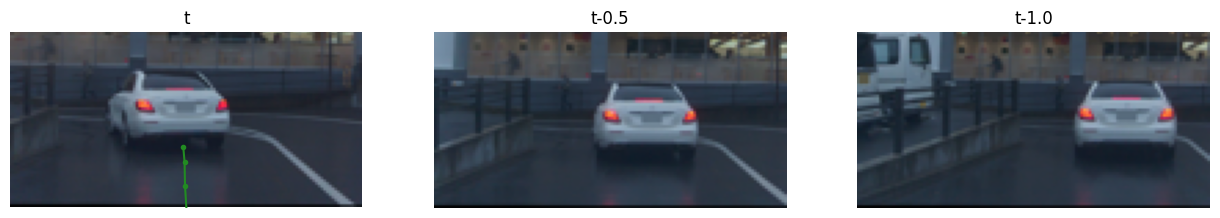

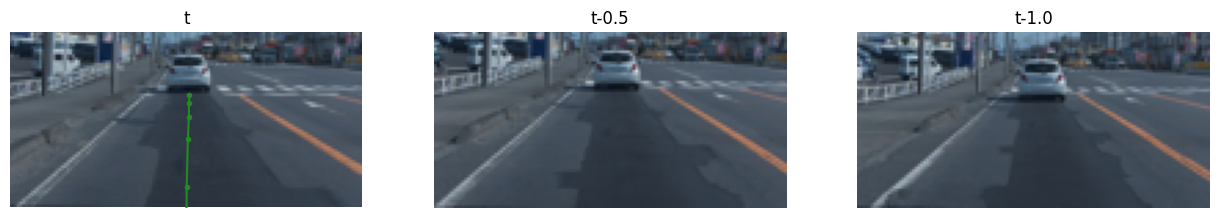

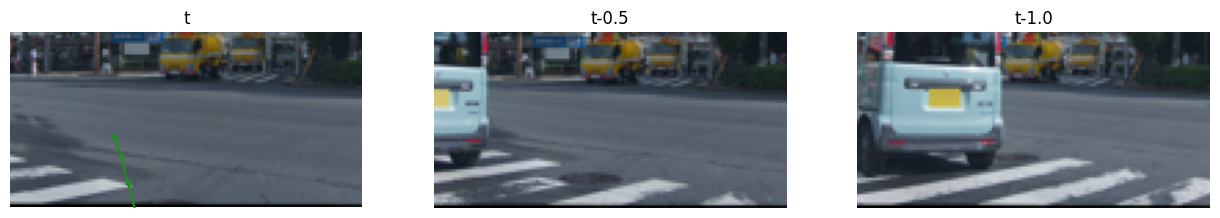

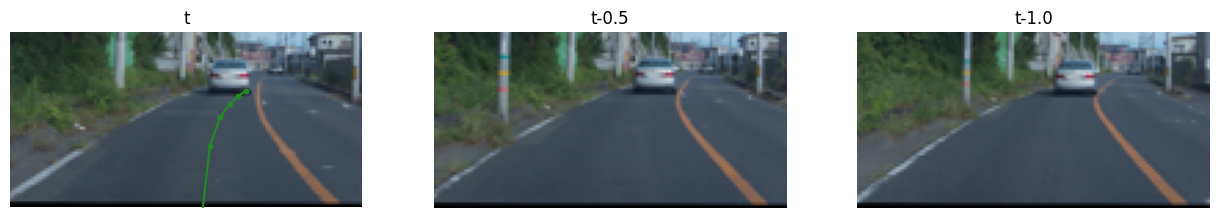

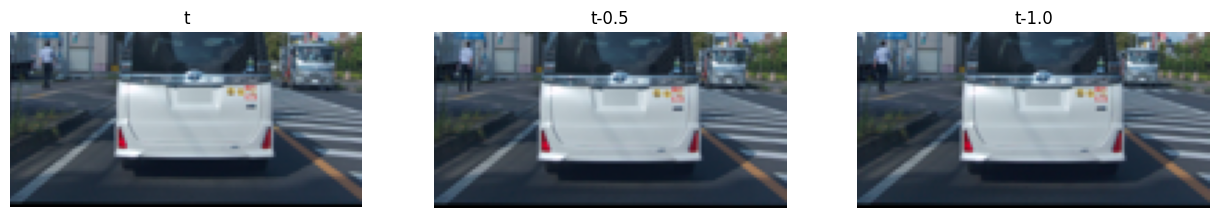

In [22]:
df_sub_check = pd.concat([
    df_feature_test,
    df_submission
], axis=1)

for i in range(0, 1000, 200):
    row = df_sub_check.iloc[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
    for t, image_path_root in enumerate(image_path_root_list):
        img = np.array(Image.open(image_path_root.format(ID=row.ID)))
        axs[t].set_axis_off()
        axs[t].imshow(img)
    
        trajectory = convert_target_to_visible_trajectory(row[TARGET_COLUMNS])
        
        if t == 0:
            trajectory_image = project_trajectory_to_image_coordinate_system(trajectory, intrinsic_matrix)
            axs[t].plot(
                trajectory_image[:, 0],
                trajectory_image[:, 1],
                marker="o",
                color="forestgreen",
                alpha=1.0,
                markersize=3,
                linestyle="solid",
            )
            axs[t].set_xlim(0, 128)
            axs[t].set_ylim(64, 0)
        
        axs[t].set_title(image_path_root.split("image_")[-1].replace('.png', ''))
    
    plt.show()
    plt.clf()
    plt.close()

In [23]:
print("自動運転楽しい！！！")

自動運転楽しい！！！
